In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import re
import string
import numpy as np
import pandas as pd
import random
import missingno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix

from wordcloud import WordCloud

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [6]:
data = pd.read_csv('fake_job_postings.csv')

In [7]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


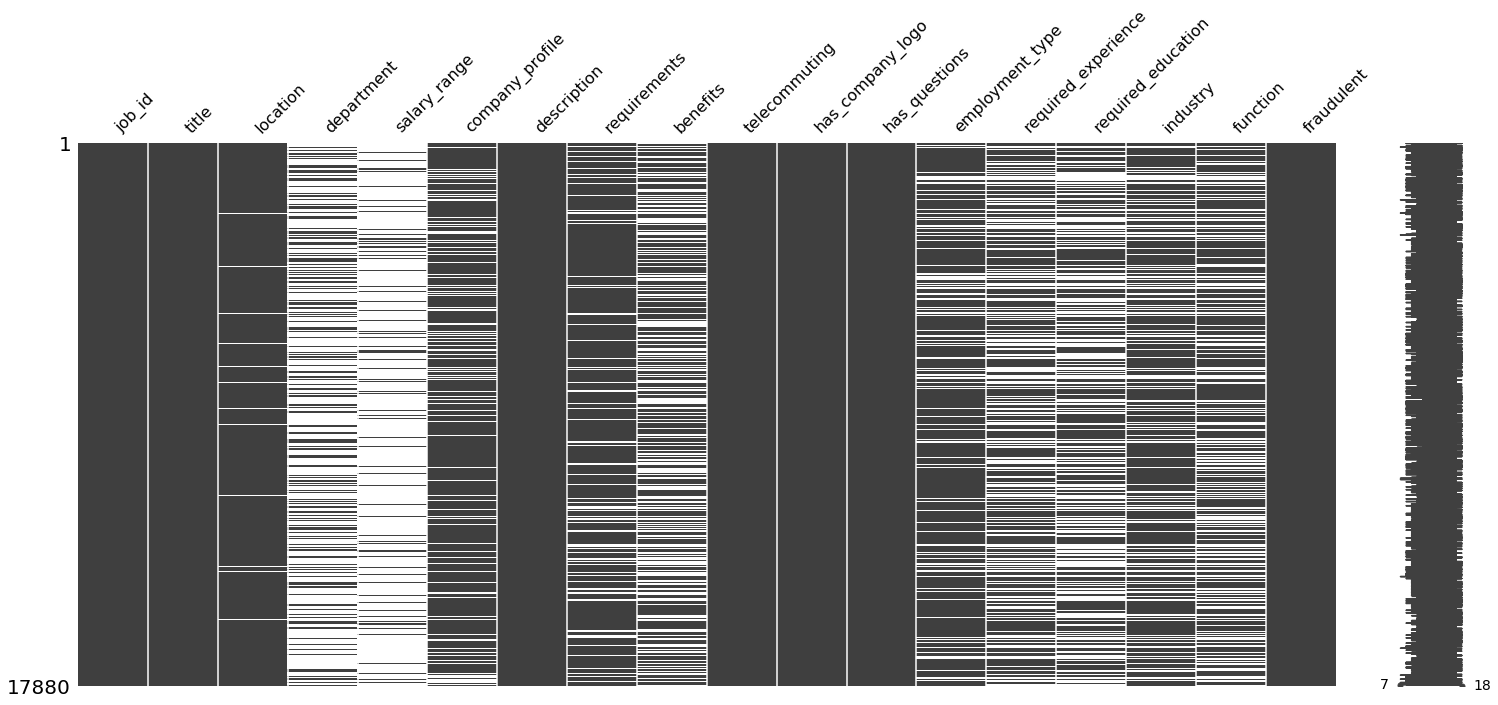

In [8]:
# checking missing data in our dataframe.
missingno.matrix(data)

* As we can see their are a lot of null values in our dataset, so we need to figure out something later about it.

In [9]:
print(data.columns)
data.describe()

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


* From describing our data we get to know that their are 4 columns named as job_id, telecommuting, has_company_logo and has_questions features which have numerical data. So we can easily remove these columns as they are of no use in text classification problems.
* We can also see one numerical feature 'fraudulent' is basically column on which our model will be trained and predicted.

,fraudulent,title
0,0,17014
1,1,866


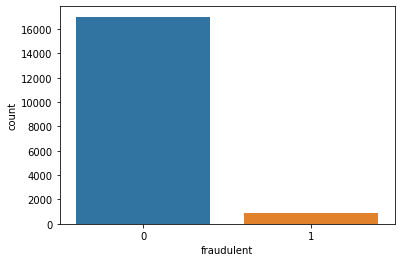

In [10]:
# Now lets see how many jobs posted are fraud and real.
sns.countplot(data.fraudulent)
data.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

* From the plot we can see their are very few fraud jobs posted.
* Our data is very much imbalanced so its a hard work to make a good classifier, we will try best :-)

### **Now let's fill the nan values and get rid of the columns which are of no use to make things simpler.**

In [11]:
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for col in columns:
    del data[col]

data.fillna(' ', inplace=True)

In [12]:
data.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


**Let's check which country posts most number of jobs.**

In [13]:
def split(location):
    l = location.split(',')
    return l[0]

data['country'] = data.location.apply(split)

Text(0.5, 0, 'Countries')

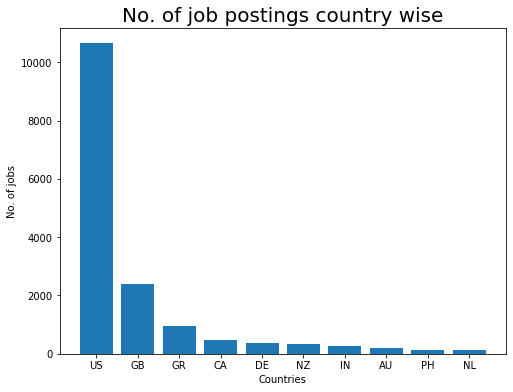

In [14]:
country = dict(data.country.value_counts()[:11])
del country[' ']
plt.figure(figsize=(8,6))
plt.title('No. of job postings country wise', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)

* Most number of jobs are posted by US.

Let's check about which type of experience is required in most number of jobs.

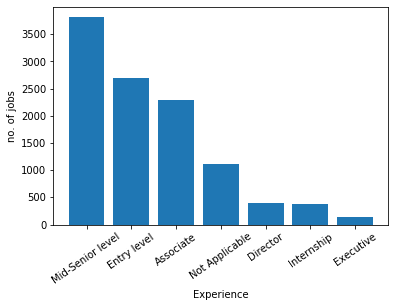

In [15]:
experience = dict(data.required_experience.value_counts())
del experience[' ']
plt.bar(experience.keys(), experience.values())
plt.xlabel('Experience', size=10)
plt.ylabel('no. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()

In [16]:
# title of jobs which are frequent.
print(data.title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


**Now we should combine our text in a single column to start cleaning our data.**

In [17]:
data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']
del data['title']
del data['location']
del data['department']
del data['company_profile']
del data['description']
del data['requirements']
del data['benefits']
del data['required_experience']
del data['required_education']
del data['industry']
del data['function']
del data['country']

In [18]:
data.head()

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."


**Now lets see what type of words are frequent in fraud and actual jobs using wordclouds**

In [19]:
fraudjobs_text = data[data.fraudulent==1].text
actualjobs_text = data[data.fraudulent==0].text

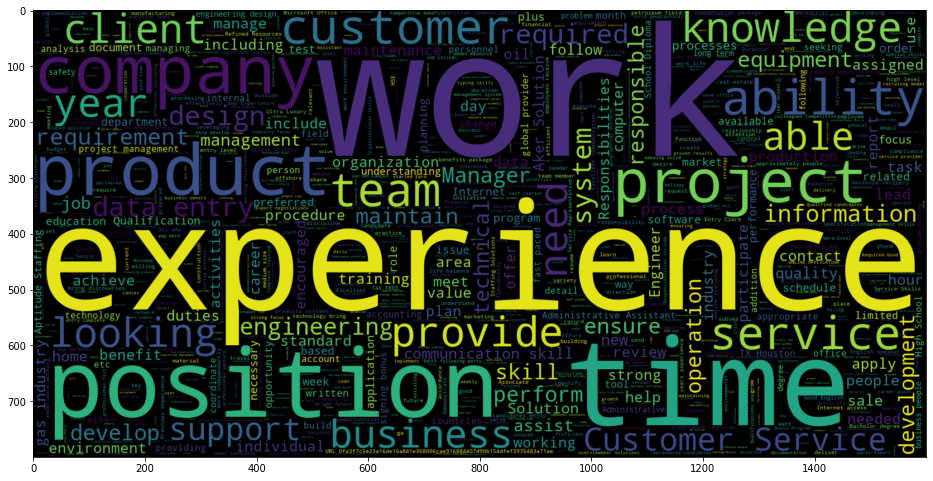

In [21]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

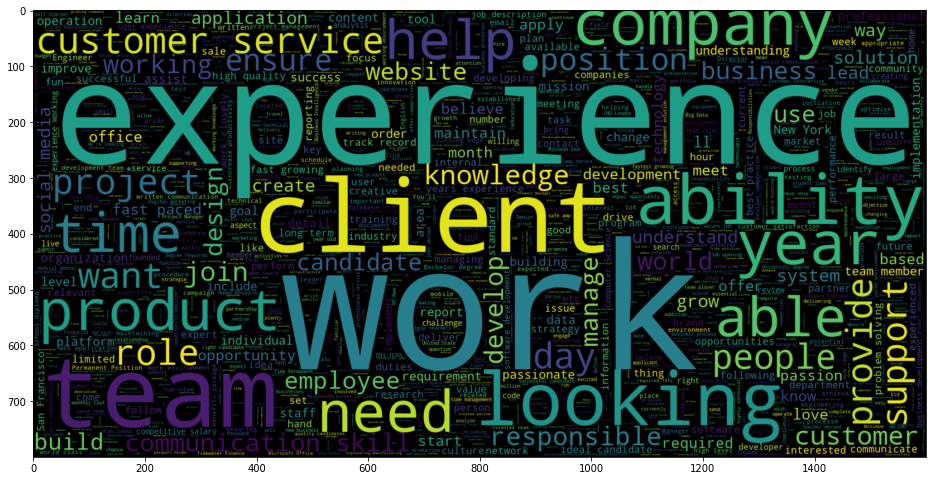

In [23]:
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

# Cleaning Data

* Creating a function that accepts a sentence as input and processes the sentence into tokens, performing lemmatization, lowercasing, and removing stop words.
* The function that i have used to do these work is found here https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/, i know that i cant write so neat so i just taken those functions.

In [24]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [35]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [36]:
# creating our bag of words
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,3))

* BoW converts text into the matrix of occurrence of words within a given document. It focuses on whether given words occurred or not in the document, and it generates a matrix that we might see referred to as a BoW matrix or a document term matrix.

In [42]:
# splitting our data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.3)
print(X_test)

14767    PR Director US, NY, New York We’re always look...
69       Ruby Automation Engineer & Ruby on Rails Engin...
10954    DL1 1LA Warehouse Apprenticeship Available Und...
2033     Human Resources Manager US, WV, Buckhannon Val...
390      Creative Strategist DE, BE,  LHBS is an unconv...
7901     PROCUREMENT MANAGER GR, I, Athens   Organizes ...
12219    Database Developer GR, I, Chalandri Neurocom i...
13854    Lead Designer US, NY, Brooklyn   Radico is bui...
16438    Software Engineer US, MI, Detroit We Provide F...
6234     English Teacher Abroad  US, CA, Corona We help...
16443    DevOps / Site Reliability Engineer (remote/tel...
6051     Business Development Manager US, TN, Nashville...
12747    Customer Account Coordinator US, WI, Milwaukee...
6671     QA - QTP Automation Engineer - Descriptive Pro...
127      Pharmaceutical / Compound Sales Representative...
16855    Senior Sysadmin GR, , Athens GRNET provides hi...
17868    CNC Programmer US, OH, Cincinnati We Provide F.

# Creating Model

* We are creating a pipeline with three components: a cleaner, a vectorizer, and a classifier. The cleaner uses our predictors class object to clean and preprocess the text. The vectorizer uses countvector objects to create the bag of words matrix for our text. The classifier is an object that performs the logistic regression to classify the sentiments.

1. Logistic Regression

In [38]:
clf = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x1a303e0610>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 tok...)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x1a2a631710>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
             

In [39]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))
print("Logistic Regression Recall:", recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9869500372856077
Logistic Regression Recall: 0.728


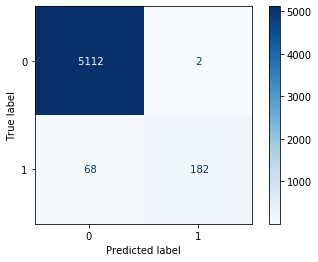

In [40]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

2. Random Forest Classifier

In [27]:
clf = RandomForestClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7fe93b0c3510>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_im

In [28]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, predicted))
print("Random Forest Recall:", recall_score(y_test, predicted))

Random Forest Accuracy: 0.9834079045488442
Random Forest Recall: 0.6836363636363636


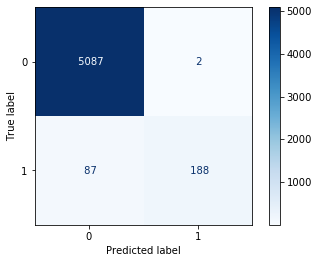

In [29]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

**3. Support Vector Machine Classifier**

In [30]:
clf = SVC()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7fe939d13210>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...ttern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7fe9744a7950>,
                                 vocabulary=None)),
                ('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3

In [31]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("SVC Accuracy:", accuracy_score(y_test, predicted))
print("SVC Recall:", recall_score(y_test, predicted))

SVC Accuracy: 0.977069351230425
SVC Recall: 0.5527272727272727


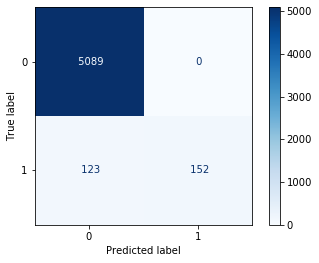

In [32]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

4. XGBoost Classifier

In [41]:
clf = XGBClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x1a36095d90>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 tok...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,


In [43]:
# Predicting with a test dataset
predicted = pipe.predict

# Model Accuracy
print("XGBoost Accuracy:", accuracy_score(y_test, predicted))
print("XGBoost Recall:", recall_score(y_test, predicted))

XGBoost Accuracy: 0.9947800149142431
XGBoost Recall: 0.8969465648854962


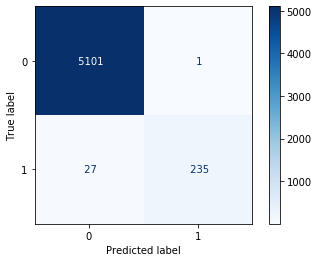

In [44]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

### * Sorry Guyz for creating Prediction section so long from next time i will do all classifiers in a loop and will try to implement tuning as i am still learning best way :-)
### * If you like the notebook please Upvote it.
### * Any kind of suggestion are appreciated.

In [45]:
import pickle

In [47]:
with open('pipe', 'wb') as f:
    pickle.dump(pipe,f)

In [48]:
with open('pipe','rb') as f:
    pipe = pickle.load(f)

In [66]:
results = pipe.predict("Technician Instrument & Controls Edison International and Refined Resources have partnered up in an effort to streamline the hiring process and provide a more efficient and effective recruitng model.¬† Our focus is to help develop and achieve your career goals while makeing a solid geographical, cultural and professional fiit when leveraging your career into your new and exciting professional venture!Please direct all communications to the HR Department within Refined Resources (#URL_80d75e0d07ca8b108539318a0443bfe5d1ff472afa0c4540b77079c5d5f31eee#)¬†#EMAIL_0b13a2cfd4718ce252c09b2353d692a73bd32552e922c5db6cad5fb7e9a2c6c3#Darren Lawson | VP of Recruiting |¬†#EMAIL_395225df8eed70288fc67310349d63d49d5f2ca6bc14dbb5dcbf9296069ad88c#¬†| #PHONE_70128aad0c118273b0c2198a08d528591b932924e165b6a8d1272a6f9e2763d1 Technician Instrument &amp; ControlsLocation Deweyville, TXLocation Name: NRG Cottonwood EnergyCategory: MaintenanceState/City: US-TX-DeweyvilleType: Full Time Hourly# Openings: 1Details About this Career Opportunity:Overview:Company Profile:We deliver cleaner and smarter energy choices for our customers, backed by the nation‚Äôs largest independent power generation portfolio of fossil fuel, nuclear, solar and wind facilities. A Fortune 500 company is challenging the U.S. energy industry by becoming the largest developer of solar power, building the first privately-funded electric vehicle charging infrastructure, and providing customers with the most advanced smart energy solutions to better manage their energy use. In addition to 47,000 megawatts of generation capacity, enough to supply nearly 40 million homes, our retail electricity providers serve more than two million customers.GENERAL SUMMARYThe Instrumentation Controls and Electrical Technician (IC&amp;E) is responsible for the maintenance and repair of all instruments, control systems and electrical equipment in the power plant and the associated facilities. The IC&amp;E Technician performs work of high skill in the inspection repair, testing, adjustment, installation and removal of all electronic and electrical power plant equipment and systems.PRIMARY FUNCTIONS-Safely perform preventive and corrective maintenance on all plant equipment, systems, and emergency backup systems.-Maintain complete equipment files, logs, and drawings for all designated equipment.-Assist in maintaining and controlling spare parts inventory to maintain plant reliability. Assist in physical inventories.-Participate in the administrative maintenance of the plant operating manuals, technical references, prints and diagrams and preventive/predictive maintenance records.-Inspect repair, install and remove all types of motors, generators, transformers, switches, control equipment, wiring, electrical signal and communication systems, and storage batteries, and work with electrical systems up to and including 4160 volts.-Conduct trouble shooting and analysis on DCS, PLC and GE Mark VI turbine control equipment.-Maintain all plant instrumentation and electrical test equipment.-Fully support and participate in NAES Safety and Regulatory Compliance Programs.-Complete other tasks as assigned by the Maintenance Manager or the Plant Manager.SCOPE OF RESPONSIBILITYThe IC&amp;E Technician operates from established and well-known procedures under minimum supervision, performing duties independently with only general direction given. Decisions are made within prescribed operating and casualty procedures and guidelines. The ICE Technician encounters recurring work situations of high complexity, with occasional variations from the norm.The IC&amp;E Technician must perform work in a safe manner resulting in no accidents, in compliance with all environmental permits at all times. The ICE Technician must effectively communicate information to supervision and fellow plant personnel, relative to the condition of the plant equipment and performance, and provide suggestions for plant improvements. The ICE Technician must perform duties in such a way to result in an optimum cost-benefit ratio.The IC&amp;E Technician may also be assigned the additional responsibility of Maintenance Coordinator/Planner for the site. This is a collateral assignment given to a selected maintenance department technician to assist the Operations and Maintenance Manager with the routine planning and coordination of the site equipment maintenance.The duties include:-The planning and review of the preventative, predictive and pro-active type maintenance.-A more in-depth knowledge and ability to use the CMMS system to provide the necessary review and planning to support the O&amp;M Manager in weekly work routines.-Ability to provide the cognitive coordinated efforts necessary to ensure that weekly routines and preventative maintenance are scheduled and documented as complete when the respective maintenance technician indicates that the work has been performed.-Provide the coordination efforts necessary in support of allowing the O&amp;M Manager to provide the necessary supervision and direction of the maintenance technicians.All employees have the responsibility to both the customer and their co-workers to do the job right the first time and to ensure the customers' needs are being met.# we are a team of almost 8,000 employees who help power almost 40 million homes and have more than 2 million residential and business customers across the country. Together, we are powering progress every day‚Äîfrom California to Texas and New Jersey to Arizona.")

In [79]:
results = pipe.predict(fraudjobs_text[98])

[0 0 0 ... 0 0 0]


NameError: name 'ts' is not defined